In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
from torchvision import transforms as tt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
import snntorch as snn
from tqdm.notebook import tqdm
from statistics import mean

Research
 - Davide Scaramuzza
 - Centernet https://arxiv.org/pdf/1904.08189.pdf
 - DECOLLE single obj detection: https://arxiv.org/pdf/2105.05609.pdf

Neuro
 - Superior Colliculus https://www.nature.com/articles/s41598-023-48979-5
 - https://www.nature.com/articles/s41562-022-01302-0
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5203770/
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6608164/
 - https://github.com/brain-score/vision
 - https://www.researchgate.net/publication/361378879_Development_of_object_recognition
 - https://www.jneurosci.org/content/37/13/3698
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10368275/

 - Tangential: https://www.jneurosci.org/content/33/4/1331

#### TODO
- [ ] Try using the mask as an output. But instead of each pixel being the class, make each pixel a vector of one-hot classes? May need to downscale img
- [x] Voxel grid

In [2]:
import sys
sys.path.append("./mnist_sg_cnn")

In [3]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

In [4]:
dir = "/media/user/EVIMO/raw/imo/eval/scene15_dyn_test_01/left_camera/ground_truth_000000"
cache_dir = "./data/EVIMO/obj_det_cache"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 8 # T = 100
framerate = 200
epochs=20
output_size=(30, 40)
input_size=(480, 640)
num_classes = 25

dtype=torch.float

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
class EVIMO(Dataset):
    def __init__(self,
                 dir: str,
                 item_to_find: int,
                 num_bins_per_frame: int,
                 #start_idx: int,
                ):
        self.dir = dir
        self.item_to_find = item_to_find
        self.num_bins_per_frame = num_bins_per_frame
        self.length = np.load(self.dir + "/length.npy")
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        
        obj_ids = item["objs_in_mask"][1:]
        if self.item_to_find in obj_ids:
            id = obj_ids.tolist().index(self.item_to_find)
            detection_masks = torch.from_numpy(item["mask"]) == torch.from_numpy(np.asarray(obj_ids[:, None, None]))
            boxes = masks_to_boxes(detection_masks)
            box = boxes[id]
        else:
            box = torch.zeros([4])

        

        #target = np.tile(target, (self.num_bins_per_frame, 1))
        #print(item["events"].dtype)
        events = np.asarray(item["events"])
        #target = target

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        # #transform = transforms.ToFrame(sensor_size=sensor_size, )
        events = frame_transform(events)

        #return {"data": events, "targets": target}
        #targets = {"boxes": box, "labels": 1}
        targets = box
        #return events, targets
        return item

    def __len__(self) -> int:
        return self.length # - self.start_idx
    
    

In [5]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dir: str,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dir = dir
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size
        self.length = np.load(self.dir + "/length.npy")

        
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()


        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        events = frame_transform(events)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        one_hot_mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        resized_mask = tt.functional.resize(one_hot_mask, self.output_size, antialias=True)
        
        return torch.from_numpy(events).to(torch.float), resized_mask.squeeze()

    def get_original_mask(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    def get_item(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        return item
    
    

In [6]:
dataset = EVIMOMask(dir="./data/EVIMO/left_cam/scene13_test5", output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [7]:
e, mask = dataset[0]

In [8]:
mask.shape

torch.Size([25, 30, 40])

In [9]:
e.shape

torch.Size([8, 1, 480, 640])

In [10]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [11]:
nn.Linear(1, 128)

Linear(in_features=1, out_features=128, bias=True)

In [12]:
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(input_size[0] * input_size[1], 128)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(128, output_size[0] * output_size[1] * num_classes)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, data):
        # Input data should be in format: Batch size, num_bins_per_frame, channel(1), x, y

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        current_batch_size = data.shape[0]
        
        data = data.transpose(0, 1) # Converting to num_bins_per_frame, batch_size, channel, x, y

        

        for step in range(num_bins_per_frame):
            x = data[step].view(current_batch_size, -1)
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))
            mem2_rec.append(mem2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [14]:
events, resized_mask = dataset[0]
events = events.to(device)
events.shape

torch.Size([8, 1, 480, 640])

In [15]:
resized_mask.shape

torch.Size([25, 30, 40])

In [16]:
out = torch.argmax(resized_mask, dim=0)

In [17]:
out.shape

torch.Size([30, 40])

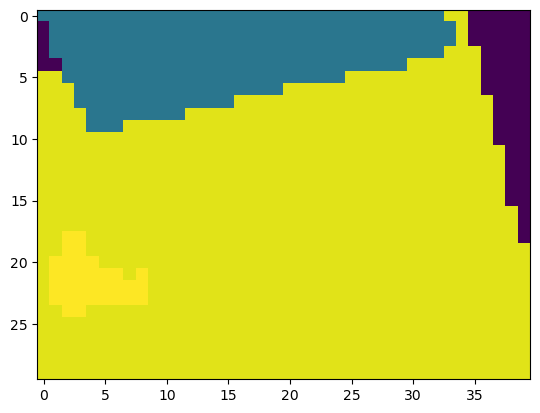

In [18]:
plt.imshow(out.tolist())

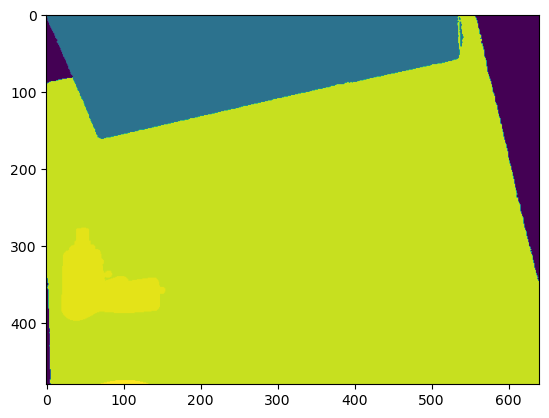

In [19]:
plt.imshow(dataset.get_original_mask(0).squeeze())

In [20]:
events, resized_mask = next(iter(trainloader))
events = events.to(device)
events.shape
events[0].shape

torch.Size([8, 1, 480, 640])

In [21]:
spk, mem = net(events)
mem.shape

torch.Size([8, 4, 25, 30, 40])

In [22]:
25*30*40*batch_size

120000

In [15]:
def compare_masks(dataset, index, time_step):
    data, mask = dataset[index]
    data = data.to(device).to(torch.float)
    data = data.reshape(1, 8, 1, 480, 640)
    
    spk_rec, mem_rec = net(data)

    output_mask = mem_rec[time_step].squeeze().argmax(dim=0)
    mask = mask.argmax(dim=0)

    fig, axes = plt.subplots(ncols=2, nrows=1)
    axes.ravel()[0].imshow(output_mask.tolist())
    axes.ravel()[0].set_title("Model Generated")
    axes.ravel()[0].set_axis_off()
    axes.ravel()[1].imshow(mask.tolist())
    axes.ravel()[1].set_title("Original")
    axes.ravel()[1].set_axis_off()

    plt.show()

    return output_mask, mask

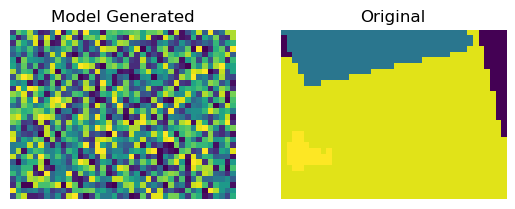

In [24]:
compare_masks(dataset, index=0, time_step=0)

Epoch 0:   0%|          | 0/120 [00:00<?, ?it/s]

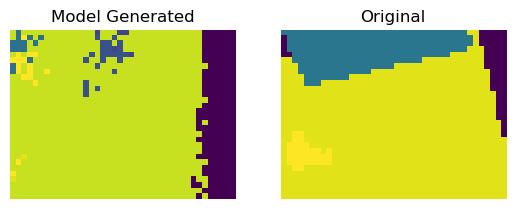

Epoch 1:   0%|          | 0/120 [00:00<?, ?it/s]

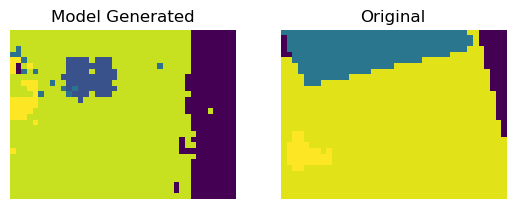

Epoch 2:   0%|          | 0/120 [00:00<?, ?it/s]

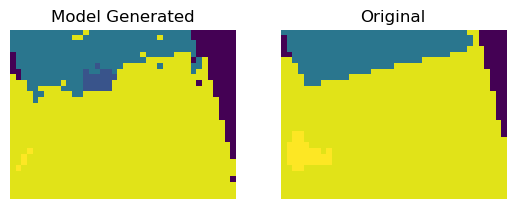

Epoch 3:   0%|          | 0/120 [00:00<?, ?it/s]

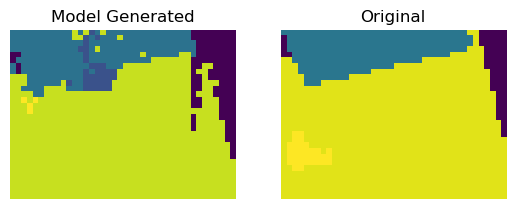

Epoch 4:   0%|          | 0/120 [00:00<?, ?it/s]

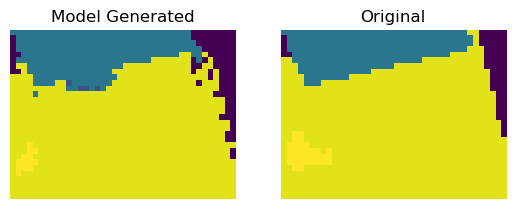

Epoch 5:   0%|          | 0/120 [00:00<?, ?it/s]

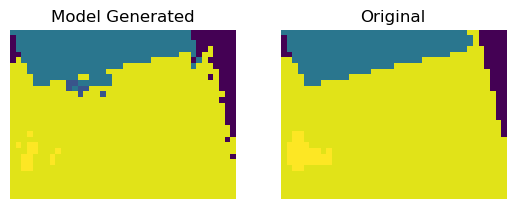

Epoch 6:   0%|          | 0/120 [00:00<?, ?it/s]

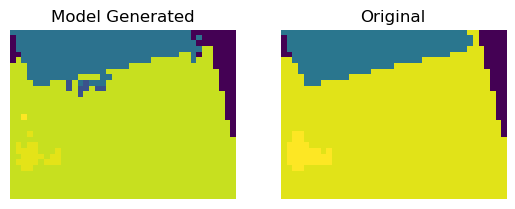

Epoch 7:   0%|          | 0/120 [00:00<?, ?it/s]

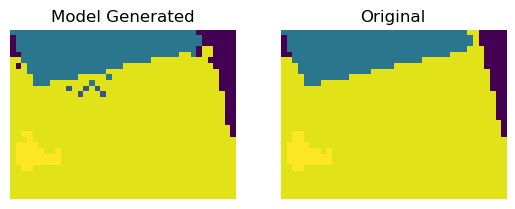

Epoch 8:   0%|          | 0/120 [00:00<?, ?it/s]

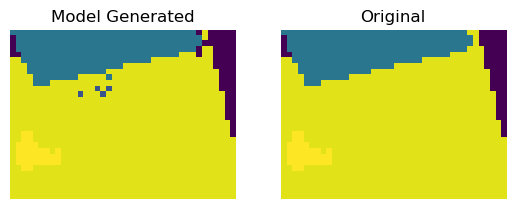

Epoch 9:   0%|          | 0/120 [00:00<?, ?it/s]

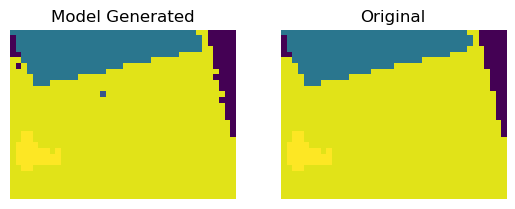

Epoch 10:   0%|          | 0/120 [00:00<?, ?it/s]

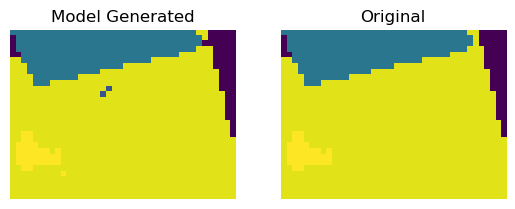

Epoch 11:   0%|          | 0/120 [00:00<?, ?it/s]

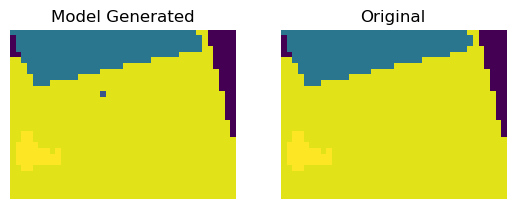

Epoch 12:   0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

# Outer training loop
for epoch in range(epochs):
    iter_counter = 0
    
    #train_batch = iter(trainloader)
    train_batch = tqdm(iter(trainloader), desc=f"Epoch {epoch}")

    # Minibatch training loop
    acc_each_batch = []
    for data, masks in train_batch:
        data = data.to(device).to(torch.float)
        masks = masks.to(device).to(torch.float)

        #print(data.shape)
        current_batch_size = data.shape[0]
        #print(data.view(batch_size, -1).shape)
        #print(masks.shape)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        acc_each_step = []
        for step in range(num_bins_per_frame):
            loss_val += loss(mem_rec[step], masks)

        #     # Getting accuracy
        #     with torch.no_grad():
        #         net.eval()
                
        #         curr_pred_mask = mem_rec[step].argmax(dim=1) # Converted into a mask that isn't one-hot. Dim 1 because 0 is batch size
        #         curr_true_mask = masks.argmax(dim=1)
    
        #         correct_class_mask = (curr_pred_mask == curr_true_mask).to(torch.float)
    
        #         pixel_based_batch_acc = correct_class_mask.count_nonzero() / correct_class_mask.numel()
        #         acc_each_step.append(pixel_based_batch_acc.item())

        
        # acc_each_batch.append(mean(acc_each_step))

        net.train()
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    #print(f"Mean Pixel-Based Accuracy for all Steps & Batches: {mean(acc_each_batch)}")

    with torch.no_grad():
        net.eval()
        compare_masks(dataset, index=0, time_step=0)

In [32]:
torch.save(net.state_dict(), "./pixel_mask_model")

In [13]:
net.load_state_dict(torch.load("./pixel_mask_model"))

<All keys matched successfully>

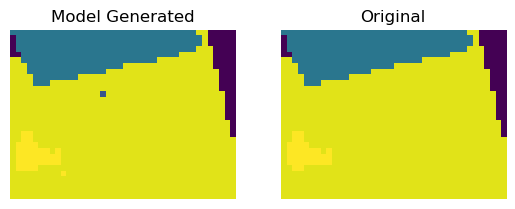

In [16]:
model_mask, mask = compare_masks(dataset, index=0, time_step=7)

In [17]:
model_mask.shape

torch.Size([30, 40])

In [18]:
model_mask.unique()

tensor([ 0,  6,  9, 22, 23], device='cuda:0')

In [19]:
from torchvision.transforms.functional import InterpolationMode

In [41]:
single_pixel_removed_model_mask = tt.functional.resize(model_mask.reshape(1, 1, 30, 40), (30, 40), antialias=True, interpolation=InterpolationMode.NEAREST_EXACT).squeeze()

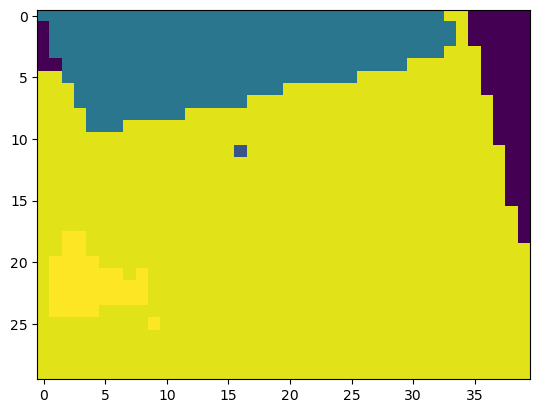

In [42]:
plt.imshow(single_pixel_removed_model_mask.tolist())

In [34]:
resized_mask = tt.functional.resize(model_mask.reshape(1, 1, 30, 40), (480, 640), antialias=True, interpolation=InterpolationMode.NEAREST).squeeze()

In [35]:
resized_mask.shape

torch.Size([480, 640])

In [36]:
resized_mask.unique()

tensor([ 0,  6,  9, 22, 23], device='cuda:0')

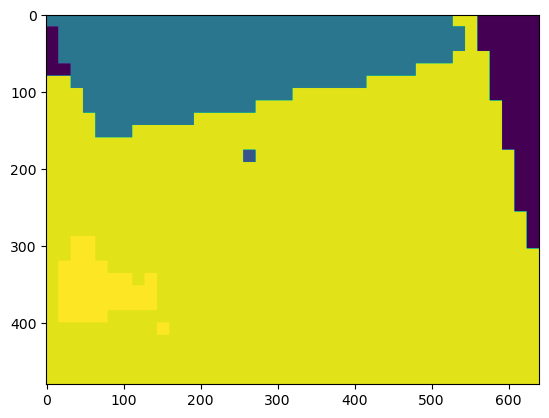

In [37]:
plt.imshow(resized_mask.tolist())

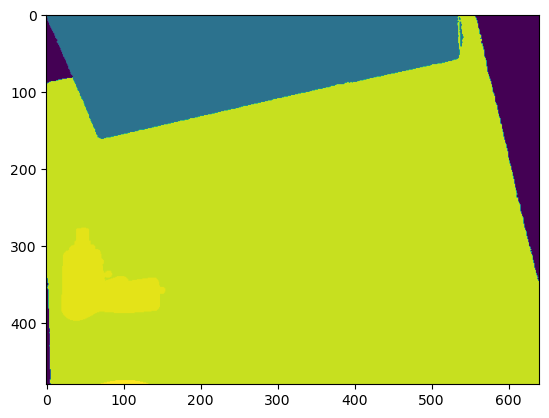

In [29]:
plt.imshow(dataset.get_original_mask(0).squeeze())

In [80]:
from torchvision.ops import masks_to_boxes
def get_bounding_boxes(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]

    masks = mask == obj_ids[:, None, None]

    boxes = masks_to_boxes(masks)

    return boxes

In [83]:
original_mask = dataset.get_original_mask(0).squeeze()
original_boxes = get_bounding_boxes(original_mask)
original_boxes

tensor([[  0.,   0., 541., 161.],
        [  0.,   0., 639., 479.],
        [ 20., 277., 154., 397.],
        [ 71., 475., 132., 479.]])

In [89]:
original_mask.shape

torch.Size([480, 640])

In [84]:
resized_boxes = get_bounding_boxes(resized_mask)
resized_boxes

tensor([[256., 176., 271., 191.],
        [  0.,   0., 543., 159.],
        [  0.,   0., 639., 479.],
        [ 16., 288., 159., 415.]], device='cuda:0')

In [95]:
from torchvision.utils import draw_bounding_boxes
plt.show(draw_bounding_boxes(original_mask.to(torch.uint8).reshape(1, 480, 640), original_boxes))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [40]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [29]:
output_mask.unique()

tensor([ 0,  6,  9, 22, 23], device='cuda:0')

In [30]:
mask.unique()

tensor([ 0,  9, 22, 23], device='cuda:0')

In [31]:
len(dataset)

477

In [33]:
307200 * 8

2457600

In [153]:
dataset = EVIMO(dir="./data/EVIMO/left_cam/scene13_test5", item_to_find=23, num_bins_per_frame=num_bins_per_frame)

TypeError: EVIMOMask.__init__() got an unexpected keyword argument 'item_to_find'

In [13]:
import os


targets = []
num_ones = 0

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

iters = 0
for i in range(len(tonic_dataset)):
    events, target = tonic_dataset[i]
    if torch.count_nonzero(target) > 0:
        targets.append(target.numpy())
        np.save(cache_dir+f"/{iters}_events", events)
        iters += 1

np.save(cache_dir+f"/targets", np.asarray(targets))
np.save(cache_dir+f"/length", iters)
    

In [8]:
class CachedEVIMODataset(Dataset):
    def __init__(self, 
                dir: str):
        self.dir = dir
        
        self.length = np.load(self.dir+f"/length.npy")
        self.targets = np.load(self.dir+f"/targets.npy")

    def __getitem__(self, index):
        events = np.load(self.dir+f"/{index}_events.npy")
        return events, self.targets[index]

    def __len__(self):
        return self.length

In [9]:
dataset = CachedEVIMODataset(dir=cache_dir)

In [10]:
len(dataset)

240

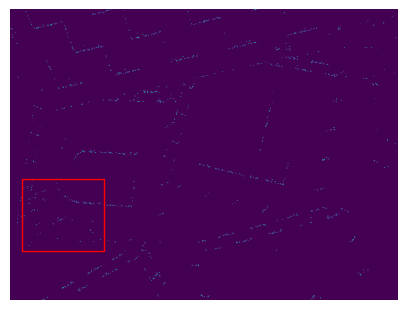

In [10]:
bins, targets = dataset[1]
bins.shape
from modified_tonic_animation import plot_animation
from IPython.display import HTML

HTML(plot_animation(bins, targets).to_jshtml())


In [12]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [25]:


loss = torch.nn.SmoothL1Loss()

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        if r[i].shape != tgt.shape:
            print(f"Loss Readout shape : {r[i].shape}")
            print(f"Loss Target shape : {tgt.shape}")
        loss_tv += loss(r[i],tgt) 
    return loss_tv


convnet_sg = lenet_decolle_model.LenetDECOLLE(out_channels=4,
                    Nhid=[64, 128], #Number of convolution channels
                    #Mhid=[256, 512],
                    kernel_size=[16, 32],
                    pool_size=[2, 4],
                    input_shape=[1, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=0,
                    lc_ampl=0.5).to(device)

#net = lenet_decolle_model.LenetDECOLLE(Nhid=[1,8],Mhid=[32,64],out_channels=2, input_shape=[2, 480, 640]).to(device)

#convnet_sg

data, target = next(iter(trainloader))
data_d = data.to(device)
convnet_sg.init_parameters(data_d) # Modifies readout dim

LAYER SIZE: 9758848
STDV: 0.00016005554609594902
LAYER SIZE: 1193216
STDV: 0.0004577311518101878


KeyboardInterrupt: 

In [23]:
from tqdm.notebook import tqdm
from torchvision.ops import box_iou

opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1e-9, betas=[0., .95])
for e in range(epochs):        
    error = []
    accuracy=[]
    for data, label in tqdm(iter(trainloader), desc=f"Epoch {e}"):
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device, dtype=torch.float)
        label_d = label.to(device)
        convnet_sg.init(data_d, burnin=10)
        readout = 0

        #print(label_d)
        #print(label_d.shape)
        #break

        data_d = data_d.transpose(0, 1)
        
        for n in range(num_bins_per_frame):
           # print(f"Data shape: {data_d[n].shape}, overall: {data_d.shape}")
            st, rt, ut = convnet_sg.forward(data_d[n])
            #print("Readout")
            #print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            #print(f"Label: {label_d[n].shape} overall {label_d.shape}")
            #print(label_d[n].shape)
            #print(label_d[n])
            loss_tv = decolle_loss(rt, st, label_d)
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]

        print("READOUT")
        print(readout)

        print("LABEL")
        print(label_d)

        print("IoU")
        IoU = torch.diagonal(box_iou(label_d, readout))
        print(IoU)

        correctly_found = torch.round(IoU)  # IoUs > 0.5 are 1's (correct), <= 0.5 are 0's (wrong)
            
        #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
        #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
        #print(correctly_found)


        error += (correctly_found == 0).float()
        accuracy += correctly_found.float()
        
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = './evimo_obj_det.pth'
    torch.save(convnet_sg.state_dict(), PATH)

Epoch 0:   0%|          | 0/60 [00:00<?, ?it/s]

READOUT
tensor([[14.0906, 17.8420, 14.6064, 14.6449],
        [16.6762, 16.2058, 14.5380, 15.7969],
        [17.2153, 15.3810, 13.5271, 14.6384],
        [15.2983, 15.3080, 11.1664, 14.2787]], device='cuda:0',
       grad_fn=<AddBackward0>)
LABEL
tensor([[ 20., 277., 154., 397.],
        [ 20., 280., 154., 399.],
        [ 20., 282., 154., 402.],
        [ 20., 285., 155., 405.]], device='cuda:0')
IoU
tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<DiagonalBackward0>)
READOUT


KeyboardInterrupt: 

In [21]:
pt = [[1, 1, 3, 3]]
pt = torch.from_numpy(np.asarray(pt))
pt2 = [[1, 1, 3, 4]]
pt2 = torch.from_numpy(np.asarray(pt2))

box_iou(pt, pt2)

tensor([[0.6667]])

In [22]:
pt = [[1, 1, 3, 3],
     [1, 1, 3, 4]]
pt = torch.from_numpy(np.asarray(pt))

torch.diagonal(box_iou(pt, pt))

tensor([1., 1.])

In [12]:
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator

In [13]:
anchor_generator = DefaultBoxGenerator([[480, 640]], 1, 1)

In [14]:
data, target = next(iter(trainloader))
data_d = data.to(device, dtype=torch.float)

In [15]:
convnet_sg.init(data_d, burnin=10)
features = convnet_sg(data_d.transpose(0, 1))

In [16]:
features[0][0].shape

torch.Size([4, 64, 119, 159])

In [17]:
len(features)

3

In [18]:
len(features[0])

5

In [19]:
num_anchors = anchor_generator.num_anchors_per_location()
num_anchors

[6]

In [20]:
from SSDHeads import *
# out_channels, num_anchors, args.num_classes
ssdhead = SSDHead([4], num_anchors, 1)

In [22]:
import torchvision.models.detection._utils as det_utils

In [24]:
num_classes = 1
box_coder_weights = [10.0, 10.0, 5.0, 5.0]
iou_threshold = 0.50

class ObjDetModule(nn.Module):
    def __init__(self):

        self.backbone = lenet_decolle_model.LenetDECOLLE(out_channels=4,
                    Nhid=[64, 128, 256], #Number of convolution channels
                    Mhid=[256, 512],
                    kernel_size=[8, 16, 32],
                    pool_size=[4, 8, 8],
                    input_shape=[1, 480, 640],  # data.shape[1:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=3,
                    num_mlp_layers=2,
                    lc_ampl=0.5).to(device)

        data, target = next(iter(trainloader))
        data_d = data.to(device)
        self.backbone.init_parameters(data_d) # Modifies readout dim


        
        self.anchor_generator = DefaultBoxGenerator([[480, 640]], 1, 1)

        out_channels = [4]
        assert len(out_channels) == len(self.anchor_generator.aspect_ratios)

        
        num_anchors = self.anchor_generator.num_anchors_per_location()
        self.head = SSDHead(out_channels, num_anchors, num_classes)

        self.box_coder = det_utils.BoxCoder(weights=box_coder_weights)
        self.proposal_matcher = det_utils.SSDMatcher(iou_threshold)

    def forward(self, events):
        
        features = self.backbone(events)

        
        head_outputs = self.head(features)
        return features, head_outputs

    def step(batch, mode):
        events, targets = batch

        features, head_outputs = self.forward(events)
        
        if mode == "train":
            self.backbone.train()
            loss_hist = 0
            data_d = data.to(device)
            label_d = label.to(device)
            self.backbone.init(data_d, burnin=10)
            readout = 0
    
            data_d = data_d.transpose(0, 1)
            for n in range(num_bins_per_frame):
                st, rt, ut = self.backbone.forward(data_d[n])
                loss_tv = decolle_loss(rt, st, label_d)
                loss_tv.backward()
                opt_conv.step()
                opt_conv.zero_grad()
                loss_hist += loss_tv
                readout += rt[-1]
    
            print("READOUT")
            print(readout)
    
            print("LABEL")
            print(label_d)
    
            #print("IoU")
            IoU = torch.diagonal(box_iou(label_d, readout))
            #print(IoU)
    
            correctly_found = torch.round(IoU)  # IoUs > 0.5 are 1's (correct), <= 0.5 are 0's (wrong)
                
            #error += (readout.argmax(axis=1)!=label_d.argmax(axis=1)).float()
            #accuracy+=(readout.argmax(axis=1)==label_d.argmax(axis=1)).float()
            #print(correctly_found)
    
    
            error += (correctly_found == 0).float()
            accuracy += correctly_found.float()